# Bản đồ có cổng dịch chuyển

**Ý tưởng**: Nếu trong mê cung có cánh cổng đi từ điểm A đến B thì trên đồ thị chúng ta sẽ thêm một cạnh nối từ A đến B và gán trọng số cạnh đó bằng 1. Bằng cách này các thuật toán sẽ tự tìm được đường đi từ START đến END mà đi qua được cổng dịch chuyển.

Phương pháp này không thực sự chỉnh sửa hàm heuristic của thuật toán nên nó không chính xác lắm. Với phương pháp này, ta thấy khoảng cách heuristic giữa cánh cổng đi vào và điểm `EXIT` vẫn bằng với trường hợp khi không có cánh cổng này. Nếu muốn "thực sự" thêm cánh cổng vào bản đồ, ta có thể định nghĩa lại hàm heuristic $h'(x)$ như sau:

$$
h'(x) = h(x) - t(x)
$$

Trong đó $t(x)$ là khoảng cách giữa điểm đi vào cánh cổng và điểm đi ra khỏi cánh cổng *nếu như* $x$ là điểm đi vào của một "đường hầm" teleport nào đó. Nếu $x$ không phải cánh cổng thì $t(x)=0$.

Tuy nhiên hàm heuristic này vẫn có một hạn chế là nó không thể nhìn thấy được các cánh cổng này từ xa. Nếu ta tính khoảng cách giữa 2 điểm nào đó mà đường đi (ước tính, có thể là chéo hoặc vuông theo Euclide hoặc Manhattan) giữa 2 điểm này vô tình khoảng cách này có đi ngang qua 2 cánh cổng (trường hợp heuristic là Manhattan sẽ gặp nhiều) thì nó vẫn chưa đủ. Tuy nhiên để đơn giản thì tụi em chỉ implement tới mức đó thôi vì thời gian cũng không còn nhiều.

## Định nghĩa các hàm cần thiết

In [1]:
%cd ../../source
import matplotlib.pyplot as plt
from teacher_utils import visualize_maze
from Graph import Graph
from searching_algorithms import *
from heuristic_func import euclide_heuristic, manhattan_heuristic

/home/hiraki/source/IntroAI/Project01/source


In [2]:
# Hàm để vẽ các cánh cổng dịch chuyển
def draw_teleports(fig, port_list):
    ax = fig.gca()
    for port in port_list:
        port_in = port[0]
        port_out = port[1]
        port_color = port[2]
        ax.scatter(port_in[1], -port_in[0], marker='D', s=50, color=port_color)
        ax.scatter(port_out[1], -port_out[0], marker='o', s=50, color=port_color)

In [3]:
# Hàm client để chạy thuật toán tìm kiếm
def run_search_nobonus(g: Graph, algorithm, heuristic=None, figsize=(5, 3), ports=[]):
    # g: đồ thị được đọc vào 
    # algorithm: con trỏ đến hàm tìm kiếm cần chạy
    g.clear()
    algorithm(g, heuristic)
    visited, path, cost = g.get_visited()
    print('Cost:', cost)
    fig = g.visualize(path, visited=visited, figsize=figsize, dont_show=True)
    draw_teleports(fig, ports)

In [4]:
# Hàm định nghĩa heuristic h'
def tunnel_wrapper(hf, coord1, coord2, port_list):
    # Nếu x là đường đi vào hầm
    for pair in port_list:
        if coord1 == pair[0]:
            return hf(pair[1], coord2) 
    # Trường hợp thông thường
    return hf(coord1, coord2)

In [5]:
def create_tunnels(g: Graph, port_list):
    # Đường vào chỉ có kề với đường ra, không kề với các điểm kác xung quanh nữa
    for port in port_list:
        g.node_list[port[0]].neighbors.clear()
        g.node_list[port[0]].neighbors.append({
            'coord': port[1], 
            'cost': 1,
            'direction': ''
        })

## Ví dụ với bản đồ không điểm thưởng số 4

Giả sử em thêm một cổng dịch chuyển từ vị trí (15, 11) đến (19, 23) vào bản đồ không điểm thưởng số 4.

In [6]:
g = Graph('testcases/nobonus4.txt')

Graph initialized from maze with size 21 x 31


Starting point (x, y) = (1, 1)
Ending point (x, y) = (19, 30)


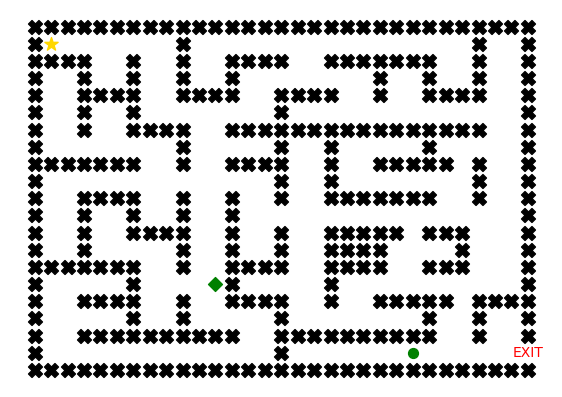

In [7]:
port_list = [((15, 11), (19, 23), 'green')]
fig = g.visualize(figsize=(7, 5), dont_show=True)
draw_teleports(fig, port_list)

In [8]:
# Tạo một cạnh nối từ (15, 11) -> (19, 23)
create_tunnels(g, port_list)

In [9]:
# Định nghĩa hàm heuristic Manhattan có xử lý cánh cổng
tunnelled_manhattan = \
    lambda coord1, coord2: tunnel_wrapper(manhattan_heuristic, coord1, coord2, port_list)

### A*

Cost: 32
Starting point (x, y) = (1, 1)
Ending point (x, y) = (19, 30)


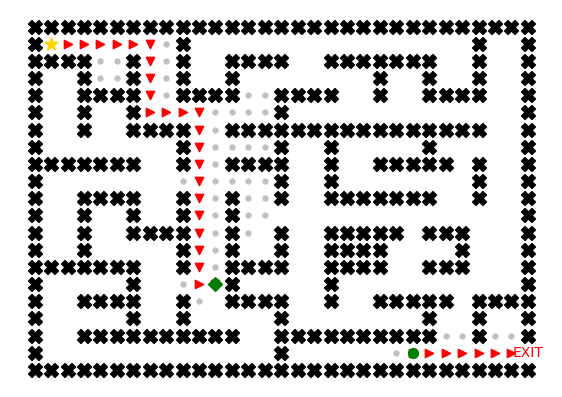

In [10]:
run_search_nobonus(g, Astar, 
                   tunnelled_manhattan, (7, 5), ports=port_list)

### Greedy Best-first Search

Cost: 32
Starting point (x, y) = (1, 1)
Ending point (x, y) = (19, 30)


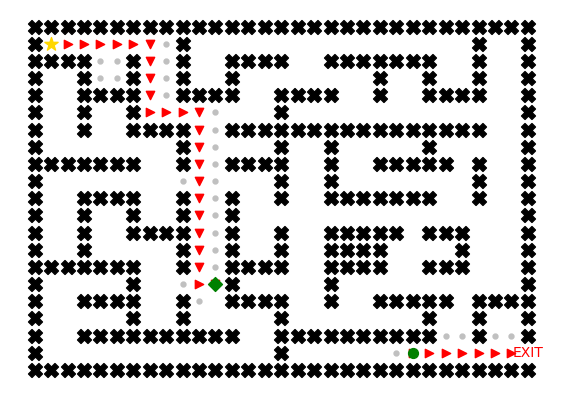

In [11]:
run_search_nobonus(g, GBFS, 
                   tunnelled_manhattan, (7, 5), ports=port_list)

Cả 2 thuật toán đều đã tìm được cánh cổng trong tất cả các . Với 2 thuật toán tìm kiếm mù còn lại cũng tương tự. 

Cần lưu ý là với hàm heuristic đã chọn thì cánh cổng chỉ thực sự phát huy tác dụng nếu nó vô tình nằm trên con đường duyệt của thuật toán (vì khi "dẫm chân" lên cánh cổng nó mới biết cánh cổng có tồn tại). Ngoài ra nó còn phụ thuộc vào chiến lược heuristic của từng thuật toán. Nếu muốn hoàn chỉnh ta có thể xét riêng hàng/cột thay vì xét hết tọa độ của điểm đang xét và tọa độ của đường vào cánh cổng. Tuy nhiên do thời gian không còn nhiều nên tụi em chỉ muốn trình bày proof-of-concept đại khái như vậy thôi ạ. Vấn đề này sẽ được em trình bày trong 2 ví dụ dưới.

## Ví dụ với bản đồ không điểm thưởng số 3 (TH1)

In [12]:
g = Graph('testcases/nobonus3.txt')

Graph initialized from maze with size 10 x 32


In [13]:
port_list = [((1, 8), (4, 24), 'green')]
create_tunnels(g, port_list)

In [14]:
# Định nghĩa hàm heuristic Euclide có xử lý cánh cổng
tunnelled_euclide = \
    lambda coord1, coord2: tunnel_wrapper(euclide_heuristic, coord1, coord2, port_list)

### A*

Cost: 24
Starting point (x, y) = (1, 1)
Ending point (x, y) = (0, 22)


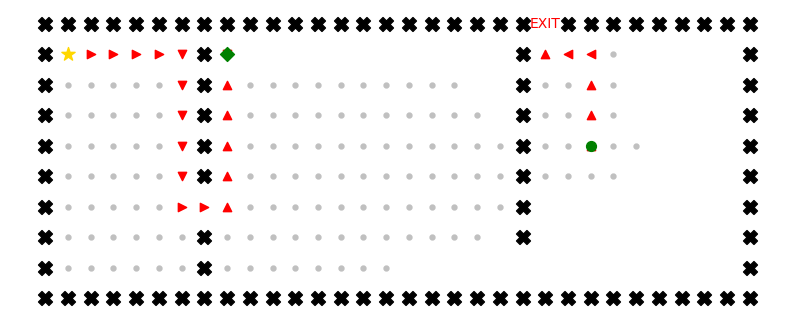

In [15]:
run_search_nobonus(g, Astar, 
                   tunnelled_euclide, (10, 4), ports=port_list)

### Greedy Best-first Search

Cost: 42
Starting point (x, y) = (1, 1)
Ending point (x, y) = (0, 22)


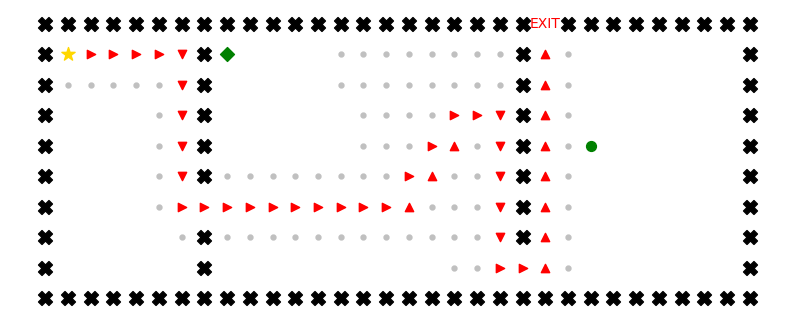

In [16]:
run_search_nobonus(g, GBFS, 
                   tunnelled_euclide, (10, 4), ports=port_list)

Ở ví dụ này ta đã thấy được việc có tìm được cánh cổng hay không còn phụ thuộc vào chiến thuật heuristic của thuật toán. Do GBFS với heuristic là Euclide đã không quét được đường vào của cánh cổng nên nó đã không tìm được cánh cổng này.

## Ví dụ với bản đồ không điểm thưởng số 4 (TH2)

In [17]:
g = Graph('testcases/nobonus3.txt')

Graph initialized from maze with size 10 x 32


In [18]:
port_list = [((1, 6), (3, 30), 'green'),
            ((2, 30), (3, 15), 'blue'), 
            ((3, 29), (2, 11), 'orange')]
create_tunnels(g, port_list)

In [19]:
# Định nghĩa hàm heuristic Euclide có xử lý cánh cổng
tunnelled_euclide = \
    lambda coord1, coord2: tunnel_wrapper(euclide_heuristic, coord1, coord2, port_list)

### A*

Cost: 19
Starting point (x, y) = (1, 1)
Ending point (x, y) = (0, 22)


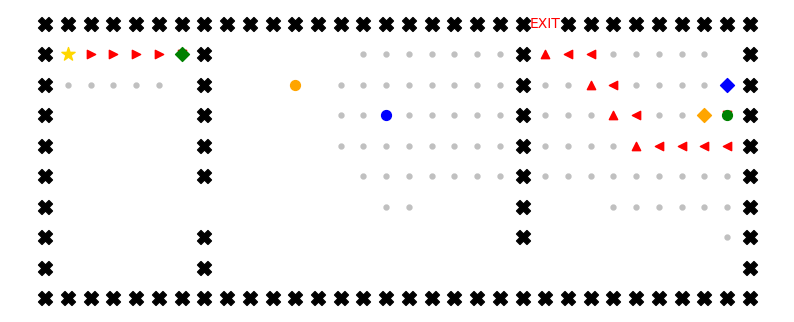

In [20]:
run_search_nobonus(g, Astar, 
                   tunnelled_euclide, (10, 4), ports=port_list)

### Greedy Best-first Search

Cost: 28
Starting point (x, y) = (1, 1)
Ending point (x, y) = (0, 22)


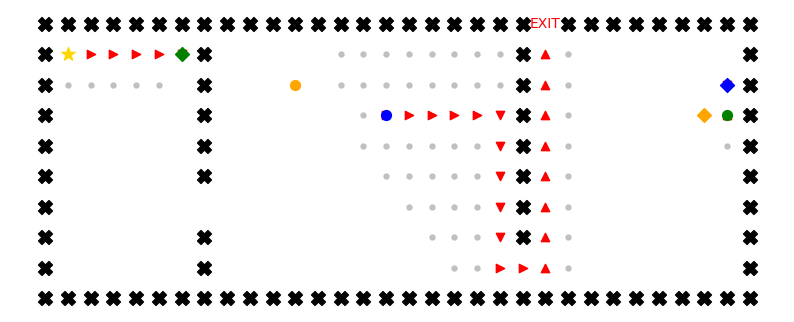

In [21]:
run_search_nobonus(g, GBFS, 
                   tunnelled_euclide, (10, 4), ports=port_list)

GBFS một lần nữa đã bị "lừa" khi cánh cổng bị "bao vây" như trên. Do đường ra của cánh cổng xanh dương sẽ gần hơn là điểm ngay phía dưới của đường ra của cánh cổng xanh lá nên nó đã chọn phương án đi vào trong cánh cổng xanh dương.

## Ví dụ với bản đồ không điểm thưởng số 5

In [22]:
g = Graph('testcases/nobonus5.txt')

Graph initialized from maze with size 31 x 71


In [23]:
port_list = [((29, 69), (15, 3), 'green')]
create_tunnels(g, port_list)

In [24]:
# Định nghĩa hàm heuristic Euclide có xử lý cánh cổng
tunnelled_euclide = \
    lambda coord1, coord2: tunnel_wrapper(euclide_heuristic, coord1, coord2, port_list)

### A*

Cost: 86
Starting point (x, y) = (1, 69)
Ending point (x, y) = (1, 0)


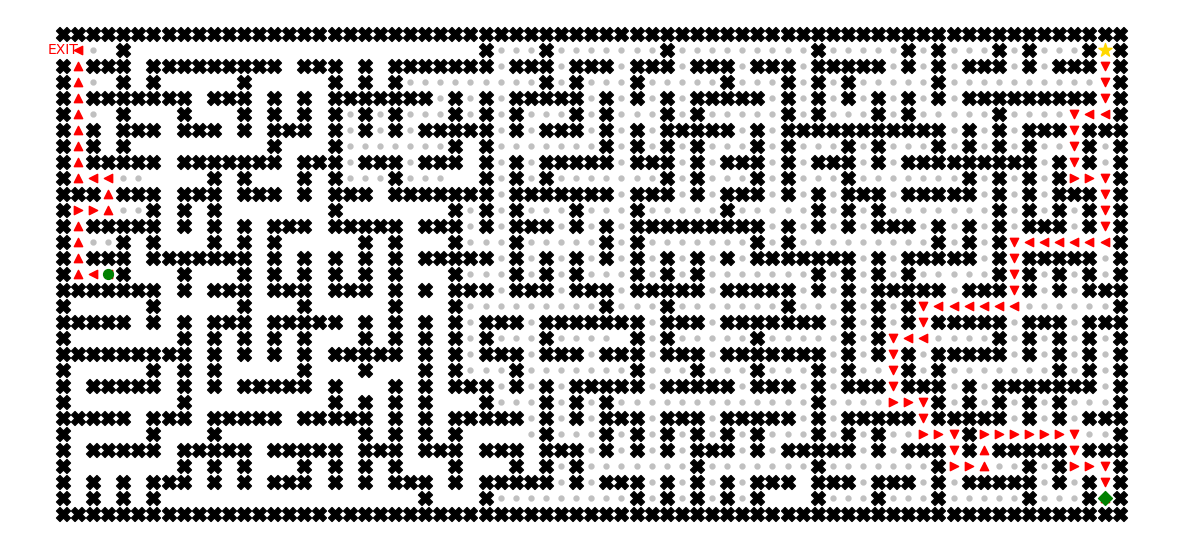

In [25]:
run_search_nobonus(g, Astar, 
                   tunnelled_euclide, (15, 7), ports=port_list)

### Greedy Best-first Search

Cost: 195
Starting point (x, y) = (1, 69)
Ending point (x, y) = (1, 0)


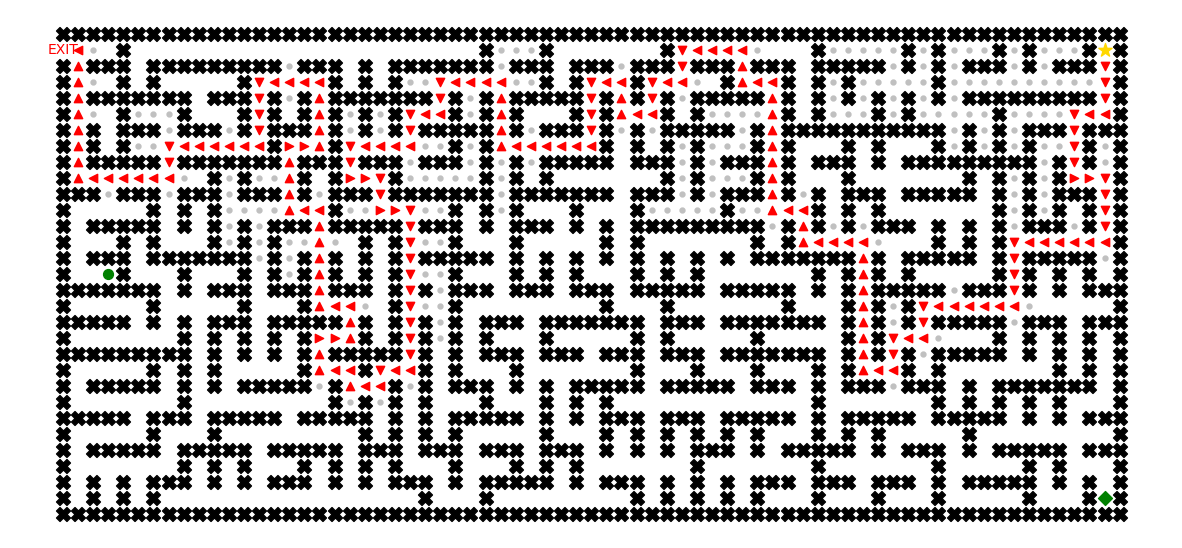

In [26]:
run_search_nobonus(g, GBFS, 
                   tunnelled_euclide, (15, 7), ports=port_list)

Ở trường hợp này ta đã thấy được rõ ràng là hàm heuristic đã được chọn để cài đặt bản đồ có điểm thưởng này không thực sự tốt, vì đáng nhẽ nếu chiến thuật "mở các ô gần đích nhất" của GBFS thực sự phát huy tác dụng thì nó đã phải đi vào cánh cổng. Nhưng hiện tại tụi em chưa nghĩ ra được phương pháp khắc phục.